# Classifying Natural Disasters

## By Jason Miller \& Charles Owens

#### Introduction
Twitter has emerged as a crucial platform for real-time information sharing, particularly during emergency situations. As a result, organizations such as disaster relief agencies and news outlets are increasingly interested in monitoring Twitter programmatically. However, distinguishing whether a tweet is a genuine disaster announcement or not can be a difficult task for machines, particularly when tweets contain metaphors or figures of speech. While such language may be easily understood by humans, it is challenging for machines to accurately interpret it. 
<br/>
<br/>
The aim of this competition is to develop a machine learning model that can accurately determine whether a tweet is related to a genuine disaster or not, using a dataset of 10,000 tweets that have been manually classified. However, this competition presents several challenges. Firstly, the dataset is relatively small, which makes it difficult to train a model accurately. One additional challenge that may be encountered in this competition is an imbalanced dataset. There may be significantly more tweets related to non-disasters than actual disasters in the dataset, which could lead to biased predictions. Furthermore, Twitter users often use different dialects and linguistic styles, which can make it challenging to capture the context of tweets accurately. Additionally, Twitter allows for open speech, which means that tweets often contain diverse textual information such as emojis, hyperlinks, URLs, and HTML. This can create a large vocabulary for most models, further complicating the training process. Tweets can be noisy and ambiguous, with many different interpretations possible. For example, a tweet that contains the word "fire" may be related to a real disaster or a metaphorical usage. This can make it challenging for models to accurately predict the correct label. 
<br/>
<br/>
This notebook outlines our efforts to create a reliable, robust, and accurate model. We first address data handling, which includes reading in the data, shuffling, and manually labeling mislabeled duplicate training examples. We also emphasize the importance of cleaning the data before model training.
<br/>
<br/>
Subsequently, we developed a baseline model that predicts a disaster-related tweet based on commonly occurring disaster-related keywords. Following this, we analyzed the data to gain a better understanding of key metrics, such as common token counts, tweet lengths, and the distribution of disaster and non-disaster tweets in the dataset. 
<br/>
<br/>
After conducting an analysis of the dataset, we began by implementing a state-of-the-art BERT model, which proved to be our most accurate model. We then decided to revisit traditional techniques by implementing a Bag of Words model. Finally, we evaluated each model's performance using key metrics, including confusion matrices, F1 scores, and ROC curves.

### Important Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # removes false positive warning
import matplotlib.pyplot as plt
import re # Text cleanup
import string # Text cleanup
import tensorflow as tf
import sklearn.metrics
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model

!pip install -q --upgrade tensorflow-hub #for BERT
!pip install -q --upgrade tensorflow-text
!pip install -q --upgrade tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.0 MB/s eta 0:00:00


### Function which takes a dataframe and predictions and transforms it into a CSV

In [ ]:
'''
The output_kaggle_test function generates a Kaggle submission file by converting model predictions to the required format and writing them to a CSV file.
Inputs: Dataframe and predictions
Outputs: None
'''
def output_kaggle_test(df, preds):
  kaggle_df = df[['id']].copy()
  kaggle_df['target'] = preds.astype(int)
  kaggle_df.to_csv('submission.csv', index = False)
  print(kaggle_df.shape)
  display(kaggle_df)


### Function to Plot Model History

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


### Data Handling

#### Reading in the Data

In [ ]:
# Import drive location where csvs are and mount
from google.colab import drive
drive.mount('/content/drive/')

# Read in using pandas
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

# Display
print('Training DataFrame')
display(train_df)

Mounted at /content/drive/
Training DataFrame


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


#### Shuffling the Indices
Shuffling indices is important because it helps to prevent the model from memorizing the order of the data during training. If the data is presented to the model in a specific order, the model may inadvertently learn to rely on this order to make predictions, leading to overfitting and poor generalization to new, unseen data. By shuffling the indices randomly, the model is exposed to a more diverse set of examples during training, which can improve its ability to generalize to new data.


In [ ]:
# Shuffle the order of the rows without touching the columns.
# Get a list of indices corresponding to the rows.
indices = np.arange(train_df.shape[0])
print('indices:', indices, '\n')

# Next, we shuffle the indices using np.random.permutation, set a random seed to get the same results each time.
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
print('shuffled indices:', shuffled_indices, '\n')

# Finally, we use dataframe.reindex to change the ordering of the original
# dataframe.
train_df = train_df.reindex(shuffled_indices)
display(train_df)

indices: [   0    1    2 ... 7610 7611 7612] 

shuffled indices: [ 311 4970  527 ... 1653 2607 2732] 



,id,keyword,location,text,target
311,454,armageddon,Wrigley Field,@KatieKatCubs you already know how this shit g...,0
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...,0
527,762,avalanche,Score Team Goals Buying @,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices i...,0
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0
...,...,...,...,...,...
4931,7025,mayhem,"Manavadar, Gujarat",They are the real heroes... RIP Brave hearts.....,0
3264,4689,engulfed,USA,Car engulfed in flames backs up traffic at Par...,1
1653,2388,collapsed,"Alexandria, Egypt.",Great British Bake Off's back and Dorret's cho...,1
2607,3742,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0


#### Manually labeling duplicate training examples
During our analysis of the training data, we observed that some text values were duplicated with conflicting labels. Initially, our plan was to remove these duplicates, but this would have resulted in a reduction in the amount of available training data. To address this issue, we decided to manually label these duplicates to prevent them from harming the training process. Rather than overwriting the original `target` column, we created a new column named `manual_target` to store these updated labels.

In [ ]:
# Find duplicates in the 'text' column the keep is set to False in order to create a boolean mask
duplicates = train_df.duplicated(subset = ['text'], keep = False)

# Keep only rows with duplicates
duplicates_df = train_df[duplicates]

# This counts the number of unique values in the target column for each of the duplicates and creates a boolean mask 
# for the ones with differening labels
mislabeled = duplicates_df.groupby('text')['target'].nunique() > 1

# Then sort them so its easier to identify which the conflicting labels
conflicting_labels = duplicates_df[duplicates_df['text'].isin(mislabeled[mislabeled].index)].sort_values(by=['text', 'target'])

# display the 'text' and 'target' columns of the filtered DataFrame
display(conflicting_labels)

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into ...,0
4221,5996,hazardous,NaN,#foodscare #offers2go #NestleIndia slips into ...,1
4239,6023,hazardous,"Mysore, Karnataka",#foodscare #offers2go #NestleIndia slips into ...,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1


In [ ]:
# Creating a new column and copy over the old targets
train_df['manual_relabeled'] = train_df['target'].copy()

# Manually re label
train_df.loc[train_df['text'] == '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect', 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'manual_relabeled'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'manual_relabeled'] = 1
train_df.loc[train_df['text'] == "Caution: breathing may be hazardous to your health.", 'manual_relabeled'] = 1
train_df.loc[train_df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'manual_relabeled'] = 1
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'manual_relabeled'] = 1
train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'manual_relabeled'] = 0
train_df.loc[train_df['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'manual_relabeled'] = 0

#### Clean the Data
Our text cleaning involved removing noise and irrelevant information from the text data, which helped to improve the quality of the model's predictions. Noise could come in many forms, including emojis, URLs, HTML tags, usernames, punctuation, and digits. Removing these elements from the text could reduce the vocabulary size and complexity of the data, making it easier for the model to extract meaningful information from it. This could improve the accuracy of the model and reduce the risk of overfitting to irrelevant information. In summary, cleaning the text data was an essential step in preparing the data for use in machine learning models, especially those that relied on textual data such as Bag of Words and BERT.

In [ ]:
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF'  
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    
    # Remove digits
    text = re.sub(r'\d+', '', text) 

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove usernames
    text = re.sub(r'@[\w]+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

# Clean the dataframe text column
train_df.loc[:, 'text'] = train_df['text'].apply(clean_text)
test_df.loc[:, 'text'] = test_df['text'].apply(clean_text)

# Display after cleaning
print('Training DataFrame')
display(train_df)

Training DataFrame


,id,keyword,location,text,target,manual_relabeled
311,454,armageddon,Wrigley Field,you already know how this shit goes world ser...,0,0
4970,7086,meltdown,Two Up Two Down,people near meltdown comics who have free ti...,0,0
527,762,avalanche,Score Team Goals Buying @,tix calgary flames vs col avalanche preseason...,0,0
6362,9094,suicide%20bomb,Roadside,if you ever think you running out of choices i...,0,0
800,1160,blight,Laventillemoorings,if you dotish to blight your car go right ahea...,0,0
...,...,...,...,...,...,...
4931,7025,mayhem,"Manavadar, Gujarat",they are the real heroes rip brave hearts,0,0
3264,4689,engulfed,USA,car engulfed in flames backs up traffic at par...,1,1
1653,2388,collapsed,"Alexandria, Egypt.",great british bake offs back and dorrets choco...,1,1
2607,3742,destroyed,USA,black eye a space battle occurred at star o i...,0,0


#### Split the Data


In [ ]:
# Split the training data 90% training and 10% validation
train_df_split = train_df[:int(0.9*len(train_df))]
train_df_split_labels = train_df_split['manual_relabeled']
validation_df = train_df[int(0.9*len(train_df)):]
validation_labels = np.array(validation_df['manual_relabeled'])

### Baseline System

In [ ]:
# baseline system which checks if the tweet contains a disaster keyword and returns 1 if true else false
# Inputs: Dataframe
# Outputs: Predictions
def baseline(df):

  # Define a set to hold keywords
  disaster_keywords = set(['earthquake', 'tsunami', 'hurricane', 'flood', 'tornado', 'wildfire', 
                         'volcano', 'cyclone', 'landslide', 'avalanche', 'blizzard', 'thunderstorm', 
                         'hailstorm', 'drought', 'heatwave', 'cold wave', 'epidemic', 'pandemic', 
                         'terrorist attack', 'explosion', 'chemical spill', 'gas leak', 'nuclear accident', 
                         'industrial accident', 'plane crash', 'train derailment', 'shipwreck', 'building collapse', 
                         'riot', 'civil unrest', 'ablaze', 'fire', 'waves', 'flooding', 'forest', 'evacuation', 'typhoon'
                         'apocolypse', 'derailment', 'emergency', 'crash', 'aftershock', 'airplane', 'killed', 'dying', 'drunk',
                         'annihilation', 'arson', 'fallout', 'attack', 'dies', 'accident', 'fight', 'fighting', 'torches', 
                         'arsonist', 'bioterror', 'bioterrorism', 'blown', 'suicide', 'bombed', 'flames', 'burned', 'burning', 'collapsed'])
  predictions = np.array([])

  # Iterate over text column in dataframe
  for text in df['text']:

      # Remove whitespace and split each text
      text_words = [word.strip() for word in text.split()]
      found = False
      for word in text_words:
          if word in disaster_keywords: 
              predictions = np.append(predictions, 1)
              found = True
              break
      if not found:
          predictions = np.append(predictions, 0)
  return predictions

#### Baseline Validation and Test Predictions

In [ ]:
# Get the predictions for the validation set
validation_predictions = baseline(validation_df)

# Give the baseline input
test_predictions = baseline(test_df)

# Output to kaggle csv
output_kaggle_test(test_df, test_predictions)

(3263, 2)


,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,0
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


### Calculating the F1 score
**Precision** is the proportion of positive predictions that were actually correct:

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

**Recall** is the proportion of actual positives that were predicted correctly:

\begin{equation}
Recall = \frac{TP}{TP + FN}
\end{equation}

**F1** is generally described as the harmonic mean of the two. Harmonic mean is just another way to calculate an “average” of values:

\begin{equation}
F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
\end{equation}

### F1 Score Function

In [ ]:
# Function expects both prediction and label vectors and returns the F1 score.
def calc_F1(predictions, labels):

  # Calculate True Positives, True Negatives, False Positives, False Negatives 
  tp = sum([1 for i in range(len(predictions)) if predictions[i] == 1 and labels[i] == 1])
  tn = sum([1 for i in range(len(predictions)) if predictions[i] == 0 and labels[i] == 0])
  fp = sum([1 for i in range(len(predictions)) if predictions[i] == 1 and labels[i] == 0])
  fn = sum([1 for i in range(len(predictions)) if predictions[i] == 0 and labels[i] == 1])

  # Find Accuracy, Precision, Recall, and F1 score
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * ((precision * recall)/(precision + recall))

  print('Accuracy:', accuracy)
  print('Precision:', precision)
  print('Recall:', recall)
  print('\n')
  print('F1:', f1)

  return f1

#### Baseline F1 Scores

In [ ]:
# Find the validation set F1
print('For the validation set:')
validation_f1 = calc_F1(validation_predictions, validation_labels)
print()

# Display the kaggle F1
print('The Kaggle test F1 score : 0.6307')

For the validation set:
Accuracy: 0.6902887139107612
Precision: 0.7340425531914894
Recall: 0.42592592592592593


F1: 0.5390625

The Kaggle test F1 score : 0.6307


### Understanding the Data

#### Disaster/Non-Disaster Count

Text(0.5, 1.0, 'Training Set Count of Disaster and Non-Disaster Tweets')

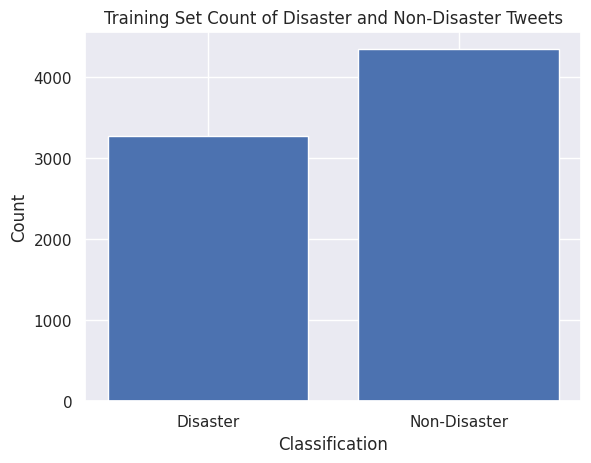

In [ ]:
# Count the number of non-disaster and disaster tweets
disaster_count = (train_df['target'] == 1).sum()
non_disaster_count = (train_df['target'] == 0).sum()

# Plot a bar chart of the counts
labels = ['Disaster', 'Non-Disaster']
counts = [disaster_count, non_disaster_count]
plt.bar(labels, counts)
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Training Set Count of Disaster and Non-Disaster Tweets')

#### Common Token Count
At first, we attempted finding the frequency of all words and displaying the top ten most frequent. Although, as expected this resulted in very common tokens being displayed such as: `the`, `a`, `and`, etc...

In [ ]:
# Define two empty dictionaries to store the word frequencies
dis_tweet_words = {}
non_dis_tweet_words = {}

# Iterate over the disaster and non-disaster tweets and count the frequency of all words
for index, row in train_df.iterrows():
    tweet = row['text'].split()
    for word in tweet:
        if row['target'] == 1:
            if word in dis_tweet_words:
                dis_tweet_words[word] += 1
            else:
                dis_tweet_words[word] = 1
        else:
            if word in non_dis_tweet_words:
                non_dis_tweet_words[word] += 1
            else:
                non_dis_tweet_words[word] = 1

# Sort the word frequencies in descending order
sorted_dis_tweet_words = sorted(dis_tweet_words.items(), key=lambda x: x[1], reverse=True)
sorted_non_dis_tweet_words = sorted(non_dis_tweet_words.items(), key=lambda x: x[1], reverse=True)     

# Print the top 10 most frequent words in each category
print("Top 10 most frequent words in disaster tweets:")
for i in range(10):
    print(sorted_dis_tweet_words[i][0], sorted_dis_tweet_words[i][1])
print()
print("Top 10 most frequent words in non-disaster tweets:")
for i in range(10):
    print(sorted_non_dis_tweet_words[i][0], sorted_non_dis_tweet_words[i][1])

Top 10 most frequent words in disaster tweets:
the 1358
in 1159
a 931
of 922
to 757
and 501
on 417
for 399
is 349
i 321

Top 10 most frequent words in non-disaster tweets:
the 1903
a 1257
to 1188
i 1077
and 917
of 901
in 818
you 664
is 595
my 544


#### Specified Token Count
Due to the results in the previous subsection, we decided to specify certain disaster keywords and find their token counts in disaster/non-disaster tweets. Additionally, we decided to add removing stopwords to our text cleaning function. \\
Note: the tokens chosen were found in the baseline function and corresponded to disaster keywords.

In [ ]:
disaster_keywords = set(['earthquake', 'tsunami', 'hurricane', 'flood', 'tornado', 'wildfire', 
                         'volcano', 'cyclone', 'landslide', 'avalanche', 'blizzard', 'thunderstorm', 
                         'hailstorm', 'drought', 'heatwave', 'cold wave', 'epidemic', 'pandemic', 
                         'terrorist attack', 'explosion', 'chemical spill', 'gas leak', 'nuclear accident', 
                         'industrial accident', 'plane crash', 'train derailment', 'shipwreck', 'building collapse', 
                         'riot', 'civil unrest', 'ablaze', 'fire', 'waves', 'flooding', 'forest', 'evacuation', 'typhoon',
                         'apocolypse', 'derailment', 'emergency', 'crash', 'aftershock', 'airplane', 'killed', 'dying', 'drunk',
                         'annihilation', 'arson', 'fallout', 'attack', 'dies', 'accident', 'fight', 'fighting', 'torches', 
                         'arsonist', 'bioterror', 'bioterrorism', 'blown', 'suicide', 'bombed', 'flames', 'burned', 'burning', 'collapsed'])


# Initialize counters for disaster and non-disaster tweets
dis_counts = {token: 0 for token in disaster_keywords}
non_dis_counts = {token: 0 for token in disaster_keywords}

# Count the number of disaster and non-disaster tweets that include each token
for index, row in train_df.iterrows():
    tweet = row['text']
    for token in disaster_keywords:
        if f" {token} " in f" {tweet} ":
            if row['target'] == 1:
                dis_counts[token] += 1
            else:
                non_dis_counts[token] += 1

# Get the top 10 tokens for disaster and non-disaster tweets
top_dis_tokens = sorted(dis_counts, key=dis_counts.get, reverse=True)[:10]
top_non_dis_tokens = sorted(non_dis_counts, key=non_dis_counts.get, reverse=True)[:10]

# Print the top 10 tokens for disaster and non-disaster tweets
print("Top 10 tokens in disaster tweets:")
for token in top_dis_tokens:
    print(f"{token}: {dis_counts[token]}")
print()
print("Top 10 tokens in non-disaster tweets:")
for token in top_non_dis_tokens:
    print(f"{token}: {non_dis_counts[token]}")

Top 10 tokens in disaster tweets:
fire: 161
suicide: 104
killed: 90
crash: 76
emergency: 74
wildfire: 69
accident: 66
burning: 63
attack: 62
forest: 46

Top 10 tokens in non-disaster tweets:
emergency: 77
fire: 68
burning: 54
crash: 30
attack: 29
burned: 28
flames: 28
blown: 28
riot: 25
collapsed: 22


#### Plotting the token counts
Let's visualize the counts of the list of tokens we just produced. \\
Notice how some key words are among the highest occurring in both disaster and non-disaster tweets.

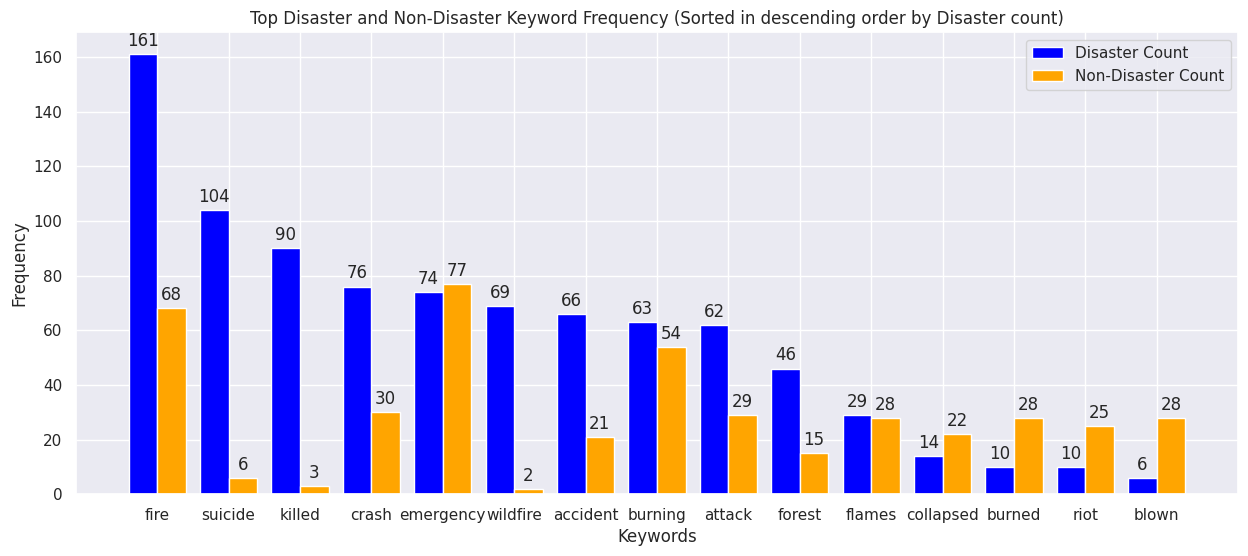

In [ ]:
def plot_top_tokens(top_dis_tokens, top_non_dis_tokens, sort_by_disaster=True):
  set_dis = set(top_dis_tokens)
  set_non_dis = set(top_non_dis_tokens)
  top_tokens = list(set_dis.union(set_non_dis))
  top_dis_freqs = [dis_counts[token] for token in top_tokens]
  top_non_dis_freqs = [non_dis_counts[token] for token in top_tokens]

  counts = [(token, dis_freq, non_dis_freq) for token, dis_freq, non_dis_freq in zip(top_tokens, top_dis_freqs, top_non_dis_freqs)]

  if sort_by_disaster:
  # Define a combined sorting key that first sorts by decreasing disaster count, then by decreasing non-disaster count
    sorting_key = lambda x: (-x[1], -x[2])
    sorted_by = '(Sorted in descending order by Disaster count)'
  else:
    sorting_key = lambda x: (-x[2], -x[1])
    sorted_by = '(Sorted in descending order by Non-disaster count)'

  # Sort the counts list using the sorting key
  counts.sort(key=sorting_key)

  # Extract the sorted tokens and counts into separate lists
  sorted_tokens, sorted_dis_freqs, sorted_non_dis_freqs = zip(*counts)

  # Set up bar chart
  fig, ax = plt.subplots(figsize=(15,6))
  ax.set_xlabel('Keywords')
  ax.set_ylabel('Frequency')
  ax.set_title('Top Disaster and Non-Disaster Keyword Frequency ' + sorted_by)
  ax.set_xticks(range(len(sorted_tokens)))

  # Set the x-axis tick labels to the keyword strings
  ax.set_xticks(np.arange(len(sorted_tokens)))
  ax.set_xticklabels(sorted_tokens)

  bar_width = 0.4
  # Plot the bars side by side
  disaster_bars = ax.bar(np.arange(len(sorted_tokens)) - bar_width/2, sorted_dis_freqs, width=bar_width, align='center', label='Disaster Count', color='blue')
  non_disaster_bars = ax.bar(np.arange(len(sorted_tokens)) + bar_width/2, sorted_non_dis_freqs, width=bar_width, align='center', label='Non-Disaster Count', color='orange')

  # Add the legend
  ax.legend()

  # Add labels for the values of each bar
  for nd_bar, nd_value in zip(disaster_bars, sorted_dis_freqs):
      ax.annotate(str(nd_value), xy=(nd_bar.get_x() + nd_bar.get_width() / 2, nd_value), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
  for nond_bar, nond_value in zip(non_disaster_bars, sorted_non_dis_freqs):
      ax.annotate(str(nond_value), xy=(nond_bar.get_x() + nond_bar.get_width() / 2, nond_value), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

  # Show the plot
  plt.show()

# Plot the tokens frequency sorted by disaster count
plot_top_tokens(top_dis_tokens, top_non_dis_tokens)

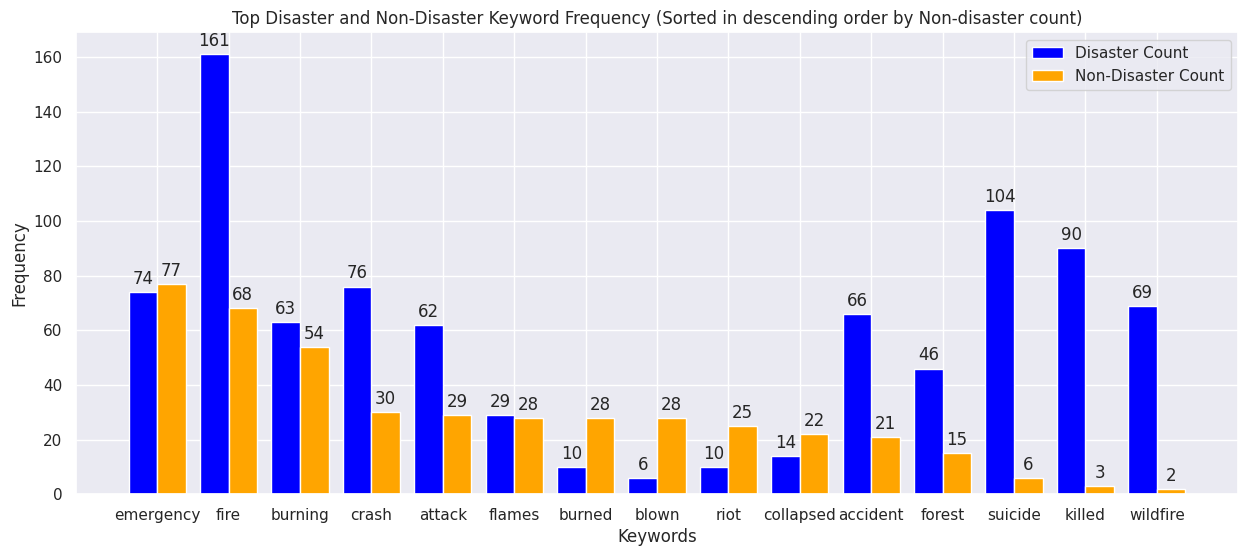

In [ ]:
# Plotting the tokens but sorted by non-disaster count
plot_top_tokens(top_dis_tokens, top_non_dis_tokens, False)

#### Finding Tweet Lengths
We want to find the lengths of the tweets to compare if there is a difference between disaster and non-disaster tweet lengths. 

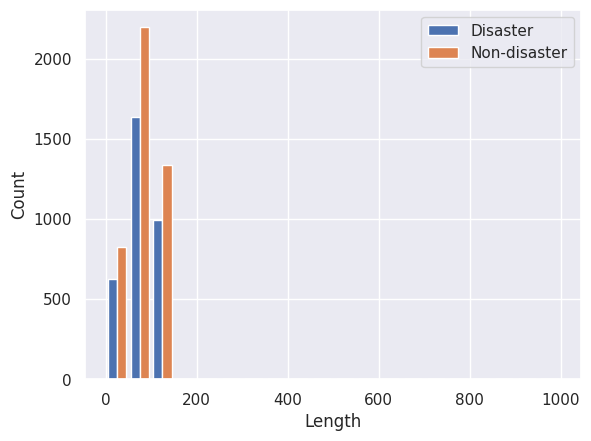

Longest disaster tweet: 145
Longest non-disaster tweet: 142


In [ ]:
# Create a list of lengths for the tweet training examples with a disaster label
tweet_lengths_disaster = [len(x) for (i, x) in enumerate(train_df['text']) if train_df['manual_relabeled'][i]]

# Create a list of lengths for the tweet training examples with a non-disaster label
tweet_lengths_non_disaster = [len(x) for (i, x) in enumerate(train_df['text']) if not train_df['manual_relabeled'][i]]

# Create a histogram
plt.hist([tweet_lengths_disaster, tweet_lengths_non_disaster], bins=20, range=(0, 1000),
         label=['Disaster', 'Non-disaster'])
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

# Check the lengths of the disaster and non-disaster tweets
print('Longest disaster tweet:', max(tweet_lengths_disaster))
print('Longest non-disaster tweet:', max(tweet_lengths_non_disaster))



#### Discussion

Our analysis of the dataset revealed that it contained more non-disaster tweets than disaster tweets, indicating a class imbalance. The bar plot visualizing this distribution provided a clear illustration of this imbalance. Furthermore, our results demonstrated that some commonly known disaster-related keywords, such as "emergency," "fire," "burning," "crash," and "blown," were also present in non-disaster tweets, making it more difficult for the model to distinguish between the two classes. In a high-dimensional space, such as the ~20k dimensional space of our BERT model, the data may be linearly separable. However, to better classify our predictions, we may need to consider additional features such as location, keywords, or other methods. In addition, the analysis of tweet lengths revealed a slight difference in length between disaster and non-disaster tweets, with non-disaster tweets being slightly longer.

### Implementing a BERT Model

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras import regularizers # for the L2 regularization
from tensorflow.keras.callbacks import EarlyStopping # for early stopping

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


We made the decision to incorporate a BERT model into our project based on its status as a state-of-the-art model, which reflects its exceptional capabilities and potential for high performance. By incorporating this cutting-edge technology into our work, we sought to not only achieve strong results, but also to explore and take advantage of the latest advancements in machine learning.

#### Which BERT Model to Fine-Tune?
After researching the BERT model, we discovered there are many options for which submodel to choose from: [List of Models](https://tfhub.dev/google/collections/experts/bert/1). We felt that the `sst2` model was the closest match. It was trained on a dataset primarily used for sentiment analysis. We believed that the emotions expressed in disaster-related tweets could be a useful feature for identifying them.
<br/>
<br/>
Later on in the project, we felt that it was too specialized toward a specific NLP task and wanted to fine tune a more generalized model and therefore switched to an uncased BERT model to better adapt it to our disaster tweet classification problem.

In [ ]:
# Load the BERT-large preprocessing model
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

# Load the BERT-large encoder model
bert = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4')

In [ ]:
#bert = hub.load('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1')
#preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

#### BERT Preprocessing


In [ ]:
test_tweet = ['Help me, there is a suicide bomber!']
text_preprocessed = preprocess(test_tweet)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2393 2033 1010 2045 2003 1037 5920 9472  999  102    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


##### What does this output mean?
The BERT model uses three keys in its preprocesses: `input_mask`, `input_type_ids`, `input_word_ids`. The `input_mask` is used to differentiate between the actual sentence content and padding, noticeably it has a `1` in the position where content is seen and a `0` for padding. The `input_word_ids` designates which sentence it is a part of, here we see `0`'s because there is only one sentence. Lastly, `input_word_ids` contains the word ids, although it is important to note that the BERT model uses subword tokenization, which means that some words are split into smaller subwords called "wordpieces" to improve the coverage of the vocabulary. This explains why the length differs from the word count in the sentence. Additionally, the shape of `input_word_ids` is `(1, 128)`, demonstrating a maximum vocabulary length. This may be changed in the future for fine tuning.




#### Example Input/Output

In [ ]:
# Preprocess the example tweet
bert_inputs = preprocess(test_tweet)

# Feed the inputs to the model
bert_results = bert(bert_inputs)

# Evaluate
print('\nSentences:')
print(test_tweet)
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Sentences:
['Help me, there is a suicide bomber!']
Pooled Outputs Shape:(1, 1024)
Pooled Outputs Values:[-0.92568094 -0.9534138   0.99997354 -0.99493843 -0.9991948   0.52450126
 -0.99974513  0.99976504  0.99170136 -0.99545044 -0.9990165   0.99999005]
Sequence Outputs Shape:(1, 128, 1024)
Sequence Outputs Values:[[-0.41657466  0.05974571 -1.0191381  ... -0.3925488   0.19406554
   0.09850413]
 [-0.29896674  0.05847688  0.02050369 ... -0.1452515   0.05997223
  -0.32201397]
 [-0.4416933  -0.15672632 -0.35585976 ...  0.23527172  0.57104975
   0.0344888 ]
 ...
 [-0.58496004  0.11645052 -0.34727442 ...  0.17048723 -0.19120865
   0.18094337]
 [-0.8341009  -0.28618482 -0.664979   ... -0.6442312   0.10628946
   0.40088147]
 [ 0.19040167  0.2493123  -0.8199258  ...  0.17754799 -0.54601544
  -0.17241457]]


##### What does this output mean?
This is a lot to digest. The `pooled_output` represents the input tweet as a whole. It has shape `[batch size, H]` where `H` represents the hidden size or dimensionality of the output vectors in each Transformer block, in this case `1024` (chosen as a hyperparameter during the training process).

The `sequence_output` represents each input token in the tweet with shape `[batch_size, seq_length, H]` the documentation refers to this as a contextual embedding for every token in the tweet.

To explain `encoder_outputs` we must first look at the BERT model on a higher viewpoint. The BERT model has multiple layers called `Transformer blocks`[1], and the encoder outputs are the results of the computations performed in each of these blocks. The outputs `["encoder_outputs"][i]` represents the output of the `i-th` Transformer block, where `i` is a number between `0` and `L-1` (L is the total number of Transformer blocks). It has a shape of `[batch_size, seq_length, 1024]`, which means that for each input sequence in the batch. The last value of this list is equal to `sequence output`. 

##### Keywords / Important Information
1. A Transformer block is composed of two main sub-blocks: the self-attention mechanism and the feedforward neural network. The self-attention mechanism allows the network to selectively attend to different parts of the input sequence, while the feedforward network applies non-linear transformations to each input element. By stacking multiple Transformer blocks together, a neural network can learn complex relationships between input sequences and their corresponding outputs.

#### Building the Classifier Model
This is a basic BERT model which includes an input, preprocessing, encoder, dropout and a dense layer with a sigmoid activation function. After training for a certain number of epochs, we realized the model began to overfit. We decided to then include a `regularization` layer to penalize overfitting as suggested by the TAs. Why did we choose `L2` instead of `L1`? We found out that `L2` is the square of the model's weights, multiplied by a regularization factor. This penalty term penalizes large weights but does not make them so close to `0` as `L1` regularization does, resulting in more evenly distributed weights across the model's features. The goal was to create a more generalized and robust model.

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweet')
    preprocessing_layer = hub.KerasLayer(preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net) 
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier',
                                kernel_regularizer=regularizers.l2(0.01))(net) 
    return tf.keras.Model(text_input, net)

Furthermore, we discovered that while dropout layers can help to prevent overfitting, a smaller dropout rate proved to be most effective in achieving optimal results for our model.

#### Example Tweet Test
This test was quite meaningless since our model has not been trained but essential to ensure that it is functioning correctly.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(test_tweet))
print(bert_raw_result)

tf.Tensor([[0.6324848]], shape=(1, 1), dtype=float32)


#### Plotting the Model

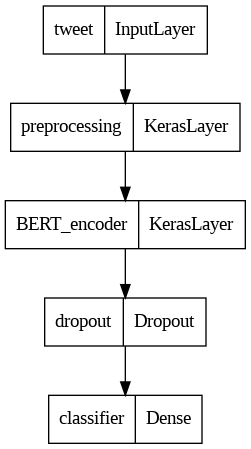

In [ ]:
# Plot the model
tf.keras.utils.plot_model(classifier_model)

After observing the large number of trainable parameters in the model, we chose not to increase its complexity further. Doing so would increase the risk of overfitting the model on the limited test data available.

In [ ]:
# Print the summary of the model to show the number of parameters per layer
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tweet (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['tweet[0][0]']                  
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

The large BERT model's impressive performance can be attributed to its vast number of trainable parameters, which enable it to capture intricate patterns in the input data. With $335,142,913$ parameters, the model has a greater capacity to learn from the training data, making it a excellent tool for accurate prediction. Additionally, this also implies that the model requires a considerable amount of computational resources and may take a longer time to train than smaller models.

#### Model Training
Given the large number of parameters in BERT, it was crucial to be vigilant about the risk of overfitting the training data. Fine-tuning the model was therefore a crucial task, one that required careful attention, as exceeding the RAM limit was a distinct possibility. While BERT comes equipped with its own preprocessor, we opted to input clean data, as this approach yielded higher F1 scores.

Furthermore, because of the complexity of the BERT model, we also experimented with various hyperparameters such as batch size, learning rate, and the number of epochs to ensure the model was appropriately tuned to our data. This approach enabled us to train the model to produce accurate predictions, while preventing overfitting to the training data.

##### Loss Function
As this is a binary classification problem, we utilized binary cross-entropy as our loss function. We modified the BERT model to output probabilities instead of logits, which required us to set the `from_logits` parameter to `False`.

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

##### Optimizer
First, we split the clean training dataframe into a training and validation set. Then, I defined a `batch_size`, which was chosen experimentally. Next, we had to convert the train and validation dataframes into something the BERT TensorFlow model needs , we used `tf.data.Dataset.from_tensor_slices` and then zipped the text and labels into the final datasets to feed it into the model. 

This code sets up an optimizer for a machine learning model using TensorFlow's `optimization` module. We set the number of epochs for training emperically. Next, we calculated the number of steps per epoch based on the size of the training dataset using `tf.data.experimental.cardinality()`. The total number of training steps is then calculated as the product of steps per epoch and the number of epochs. A warm-up period is also included by computing the number of warm-up steps as 10% of the total number of training steps. 

Finally, an AdamW optimizer is created using the specified initial learning rate, the number of training steps, the number of warm-up steps, and the optimizer type.


In [ ]:
batch_size = 8 # was 16 but ran out of memory
train_split_ds = tf.data.Dataset.from_tensor_slices(train_df_split['text'].values)
train_split_labels = tf.data.Dataset.from_tensor_slices(train_df_split['manual_relabeled'].values)

validation_ds = tf.data.Dataset.from_tensor_slices(validation_df['text'].values)
validation_ds_labels = tf.data.Dataset.from_tensor_slices(validation_df['manual_relabeled'].values)
train_ds = tf.data.Dataset.zip((train_split_ds, train_split_labels)).batch(batch_size)
val_ds = tf.data.Dataset.zip((validation_ds, validation_ds_labels)).batch(batch_size)

epochs = 1 # Set to 1 to avoid overfitting
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5 # Learning rates like 1e-3 are too large??
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')                                      

Learning Rates: <br/>
To fine-tune our large BERT model, we experimented with different initial learning rates and leveraged the smaller BERT model to save time, given the extensive training time required for the larger model.

| Initial Learning Rate | Batch Size | Max Validation Accuracy |
| :---: | :----------------: |:----------------:
| $1e^{-6}$ |16|      0.7283       | 
| $2e^{-5}$ |16|      0.8228       | 
| $1e^{-5}$ |16|      0.8241       | 
| $1e^{-4}$ |16|      0.8215       | 
| $1e^{-3}$ |16|      0.5748       | 

Based on our experimentation, we found that a learning rate of $2e^{-5}$ provided the best results.

##### Compiling

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

##### Training
We implemented early stopping as this model was very easy to overfit given its large parameter count and wanted to maximize its validation accuracy. The patience parameter means the model will stop training after the given `i-th` consecutive argument without an increasing `val_binary_accuracy`, we also set `restore_best_weights` to true to restore its best weight values. This was imperitive to our fine-tuning process.

Furthermore, we observed that the validation loss was increasing even as the validation accuracy was improving, which is indicative of overfitting. Therefore, in order to prevent further overfitting, we made the decision to limit the training of this model to only one epoch.

In [ ]:
# Implemented early stopping
early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=2, mode='max', restore_best_weights=True)

# Fit the model
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[early_stopping])

857/857 [==============================] - 294s 294ms/step - loss: 0.4788 - binary_accuracy: 0.8065 - val_loss: 0.4389 - val_binary_accuracy: 0.8412


#### Test Predictions

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices(test_df['text'].values).batch(batch_size)
predictions = classifier_model.predict(test_ds)

408/408 [==============================] - 37s 86ms/step


##### Thresholding and Outputting to Kaggle
The last layer of our model was an output sigmoid layer, therefore have to threshold in order to convert them into binary outputs.

In [ ]:
threshold = 0.5
binary_predictions = np.where(predictions >= threshold, 1, 0)
output_kaggle_test(test_df, binary_predictions)

(3263, 2)


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


#### Error Analysis

##### Finding F1 for the validation and Kaggle Test set

In [ ]:
# Get the validation dataset predictions
validation_predictions = classifier_model.predict(val_ds)

# Threshold to get valid binary outputs
threshold = 0.5
validation_binary_predictions = np.where(validation_predictions >= threshold, 1, 0)

96/96 [==============================] - 10s 88ms/step


In [ ]:
# Find the validation set F1
print('For the validation set:')
# Find the validation set F1
f1 = f1_score(validation_labels, validation_binary_predictions)

print('Validation set F1:', f1)
print()

# Display the kaggle F1
print('The Kaggle test F1 score : 0.84737')

For the validation set:
Validation set F1: 0.8026101141924961

The Kaggle test F1 score : 0.84737


##### Confusion Matrix

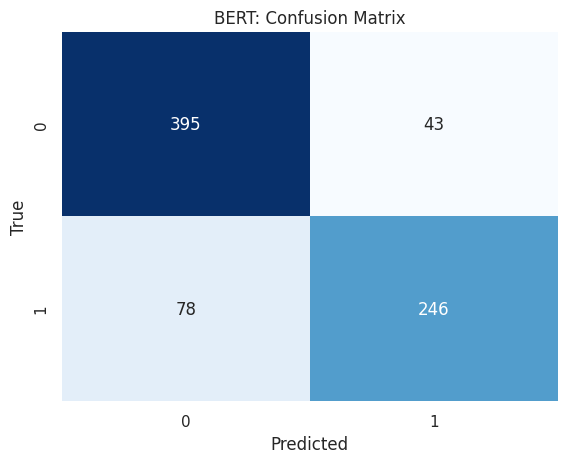

In [ ]:
# Create the confustion_matrix and display
conf_matrix = confusion_matrix(validation_df['manual_relabeled'], validation_binary_predictions)

# Use the sns heatmap as before
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT: Confusion Matrix')
plt.show()

##### ROC Curve

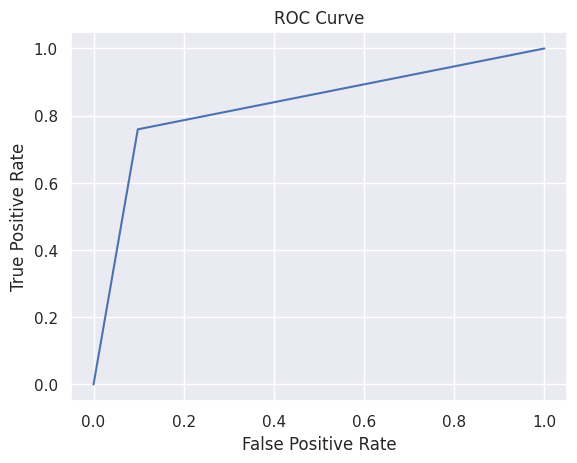

In [ ]:
# Calculate the fpr and tpr values using the roc_curve function
fpr, tpr, thresholds = roc_curve(validation_labels, validation_binary_predictions)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

##### Area Under the ROC curve (AUC-ROC)

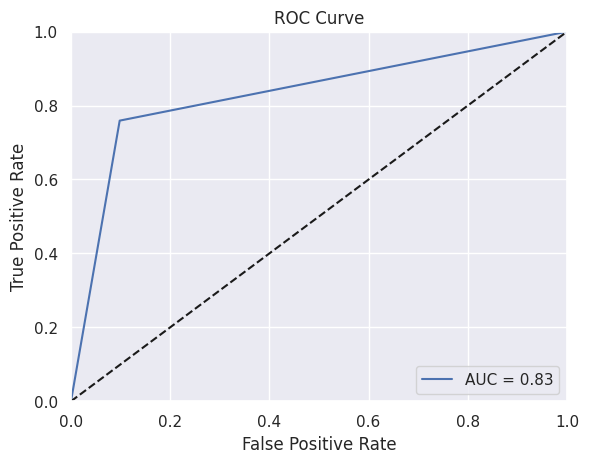

In [ ]:
# Calculate AUC score
auc_score = roc_auc_score(validation_labels, validation_binary_predictions)

# Calculate fpr, tpr values using roc_curve function
fpr, tpr, thresholds = roc_curve(validation_labels, validation_binary_predictions)

# Plot ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

##### Example Errors
To gain insight into why our model may be misclassifying tweets, we opted to showcase five examples of false positives and false negatives.

In [ ]:
# Get the indices for wrong predictions
error_indices = np.where(validation_df['manual_relabeled'] != validation_binary_predictions.reshape(-1))

# Get the indices for wrong predictions
error_indices = np.where(validation_df['manual_relabeled'] != validation_binary_predictions.reshape(-1))

fp_count, fn_count = 0, 0
i = 0
# Get five fp and fn
while fp_count < 5 or fn_count < 5:
    index = error_indices[0][i]
    true_label = validation_df.iloc[index]['manual_relabeled']
    predicted_label = binary_predictions[index]
    
    if true_label == 0 and predicted_label == 1 and fp_count < 5:
        print(f"Text: {validation_df.iloc[index]['text']}")
        print(f"True label: {true_label}, Predicted label: {predicted_label}")
        print("\n")
        fp_count += 1
    
    if true_label == 1 and predicted_label == 0 and fn_count < 5:
        print(f"Text: {validation_df.iloc[index]['text']}")
        print(f"True label: {true_label}, Predicted label: {predicted_label}")
        print("\n")
        fn_count += 1
        
    i += 1


Text: photo lavenderpoetrycafe trauma memories are encoded in images as trauma is a more sensory than cognitive 
True label: 1, Predicted label: [0]


Text: û÷good samaritansûª shot in horror hijacking  chat twimbos zimpapersviews
True label: 1, Predicted label: [0]


Text:  what alternatives legal alternatives protesting rioting may not be the most peaceful thing but its a demonstration of how
True label: 0, Predicted label: [1]


Text:  no prob
True label: 1, Predicted label: [0]


Text: ûï yo forreal we need to have like an emergency action plan incase donald trump becomes presidentû
whipe that lil baby
True label: 1, Predicted label: [0]


Text: i scored  points in punch quest stopped when a squeaky bat collided into my skull 
True label: 1, Predicted label: [0]


Text:  efs  star wars and star trek collide on pluto moon charon pluto
True label: 0, Predicted label: [1]


Text:  you said they are terrorist because of babri so was it ok if you demolish my house todayhave i right

##### Discussion
The Kaggle F1 score is notably higher than the validation set, possibly due to the larger size of the test dataset, allowing the model to generalize better. However, the confusion matrix reveals that the model predicts more false negatives than false positives, possibly because of the class imbalance in the training dataset. To address this issue, we would recommend augmenting the dataset with more disaster-related tweets.
<br/>
<br/>
The ROC curve provides a graphical representation of the trade-off between the true positive rate (TPR) and the false positive rate (FPR), enabling us to determine the optimal threshold value for our model. The optimal threshold value is the point on the curve closest to the upper left corner, which represents high TPR and low FPR. However, even after identifying the optimal threshold value, which appeared to be approximately 0.8, we found that using a threshold value of 0.5 resulted in higher accuracy for our model. This suggests that the threshold value is not the only factor influencing the model's performance, and that other factors, such as the choice of hyperparameters, may also be important.
<br/>
<br/>
The AUC ROC curve, similarly to the ROC curve, provides a visual representation of the trade-off between the true positive rate (TPR) and the false positive rate (FPR). It measures the ability of the model to distinguish between positive and negative classes, regardless of the threshold value used to classify the data.

Our AUC ROC score was identified as 0.83, demonstrating quite a powerful model.
<br/>
<br/>
Upon examining the errors, it appears that the model's incorrect predictions are due to the noise and ambiguity present in the text data and the class imbalance in the dataset. The model may struggle to accurately identify disaster-related tweets, while the bias towards the majority class (non-disaster tweets) further complicates the issue, especially given the synonymous keywords in the text.
<br/>
<br/>
Moreover, the model's training process portrays overfitting to the training data and not generalizing well to new data. The model's hyperparameters, such as the learning rate and batch size, may have also played a role in its performance, although we emperically chose these.
<br/>
<br/>
Please note that while we achieved better results with a previous BERT model, we encountered difficulty in identifying the correct timestamp in our notebook. As a result, we reverted to the closest available version from our memory.

##### Analysis
Possible ways to improve the model's performance involve augmenting the training dataset with more disaster-related tweets to address the bias towards the non-disaster class highlighted in the error analysis. One approach to increase the size of the dataset is to use techniques like data synthesis and phrase replacement to generate new training examples.

Moreover, there is a BERT model trained specifically on Twitter data, which may capture more contextual relationships. However, due to unfamiliarity with PyTorch, we decided not to pursue this option.

It may also be worth exploring different model architectures and ensemble methods to further enhance the performance of the model.

### Implementing a Bag of Words model

In addition to implementing a BERT model, we also chose to incorporate a bag of words model into our project, as it represents a classic and straightforward approach to text classification that has been used extensively in the field. Our aim with this choice was to showcase the effectiveness of a basic yet powerful model, which could provide an instructive contrast to the complexity of the BERT model.

The bag of words model operates by representing each input text as a collection of individual words or tokens, without any consideration for the sequence or context in which they appear. This approach has been shown to be highly effective in many text classification tasks, particularly those involving relatively simple classification problems with limited variability in the input data.

By using a bag of words model alongside a cutting-edge model such as BERT, we were able to provide a more comprehensive and informative picture of the trade-offs between simplicity and complexity in text classification. Furthermore, this approach allowed us to more thoroughly explore the characteristics and limitations of each model type, and to make more informed decisions regarding which model to use in different contexts.

#### Building a vocabulary

Let's make a dictionary mapping words to IDs.

In [ ]:
def build_vocab(text):
  words = []
  for i in range(len(text)):
    tweet = text[i].split()
    for word in tweet:
      if word not in words:
        words.append(word)
  
  # Assigning an index to each word
  vocab = dict([(words[i], i+1) for i in range(len(words))]) 

  vocab['#'] = 0 # In the case words of outside of the vocab

  return vocab


vocab = build_vocab(train_df['text'])
index = dict([(value, key) for (key, value) in vocab.items()])

print(len(vocab))

15041


#### Feature Representation

A tweet has a variable number of ordered tokens (up to 145 in the training examples). Each token occurs in a particular position. Some of the trailing positions are empty, since tweet lengths vary.  At each token position, there is a single token, one of the 15041 entries in the vocabulary. So we can think of a tweet as a (145, 15041) matrix: At each of ~145 token positions, we have 1 of ~15041 token ids.
<br/>
<br/>
This representation would have 145 * 15041 = 2.18 million features -- which is a lot of complexity, though as you'll see below, we will make some simplifying assumptions, reducing both the number of token positions and the number of vocabulary items.

##### Encoding the text

Using our newly-made vocabulary, let's encode the tweets so that each word in each tweet is now it's vocabulary ID.

In [ ]:
def encode(tweet):
  encoded = []
  for word in tweet.split():
    if word in vocab.keys():
      encoded.append(vocab[word])
    else:
      encoded.append(vocab['#'])
  return encoded


encoded_train_df_text = train_df['text'].apply(encode)
print(encoded_train_df_text[0])
train_df_90_encoded_text = train_df_split['text'].apply(encode)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Here is a decoding function to show the difference between the encoded tweet and the original tweet. This will not be in use in our model.

In [ ]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

print(decode(encoded_train_df_text[0]))

our deeds are the reason of this earthquake may allah forgive us all


##### Padding and Reducing the Length

As is clear from the length histogram in the <b>Finding Tweet Lengths</b> section, the current representation of the tweet text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, let's add special padding tokens at the end of each tweet until they are all the same length.

Since the tweets are each only 145 length, we will make the length for all of our tweets 145.

In [ ]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  sequences_np = sequences.to_numpy()
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences_np, maxlen=max_length, padding='post', value=0)))

# Pad and truncate to 145 tokens
train_df_90_padded = pad_data(train_df_90_encoded_text, max_length=145)

# Check the padded output.
print('Length of train_df_90_encoded_text[0]:', len(train_df_90_encoded_text[1]))
print('Length of train_df_90_padded[0]:', len(train_df_90_padded[1]))
print(train_df_90_padded[1])

Length of train_df_90_encoded_text[0]: 7
Length of train_df_90_padded[0]: 145
[   37    16   694 11696   613   276   666   235    23   111    25  2875
    77   492  1102     3   251    52 11697 11698     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


##### Reduced Vocabulary
We also want to be able to limit the vocabulary size. Since our padding function produces fixed-length sequences in a numpy matrix, we can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

In the code below, as an example, we'll keep just token ids less than 1000, replacing all others with OOV.

In [ ]:
def limit_vocab(sequences, max_token_id, oov_id=0):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

# Reduce vocabulary to 1000 tokens
train_df_90_reduced = limit_vocab(train_df_90_padded, max_token_id=1000)
print(train_df_90_reduced[1])
print(decode(train_df_90_reduced[1]))

[ 37  16 694   0 613 276 666 235  23 111  25   0  77 492   0   3 251  52
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
people near meltdown # who have free time to wait in # on sunday # are not a # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


##### Applying to validation set

In [ ]:
validation_train_df_encoded_text = validation_df['text'].apply(encode)
validation_train_df_padded = pad_data(validation_train_df_encoded_text, max_length=145)
validation_train_df_reduced = limit_vocab(validation_train_df_padded, max_token_id=1000)

#### Building the Bag of Words Model

To build our Bag of Words model, we implemented a feed-forward neural network model that expects the padded sequence of token ids and for each id, looks up the corresponding embedding vector. Then we average them to produce a single vector. Then we'll train a logistic regression with that vector as input to predict the binary label.
<br/>
<br/>
In addition to the embedding layer and the output layer, we added 5 hidden layers, each with relu activation, for added complexity and to achieve better performance.

Building with FFNN as a baseline

As this is a binary classification problem, we utilized binary cross-entropy as our loss function. We set the number of epochs for training emperically.
Additionally, an `adam` optimizer is used by specifizing the optimizer type.
<br/>
<br/>
The `adam` optimizer failed when we tried to adjust it's learning rate. However, in comparison to other optimizer's it;s one of the best with its momentum effect to prevent taking too long to converge to an optimum.

In [ ]:
def build_bow_model(vocab_size=1000,
                    sequence_length=145,
                    embedding_dim=2):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(units=120, activation='relu'))
  model.add(tf.keras.layers.Dense(units=120, activation='relu'))
  model.add(tf.keras.layers.Dense(units=120, activation='relu'))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=['accuracy'])
  return model

Building and Plotting the model

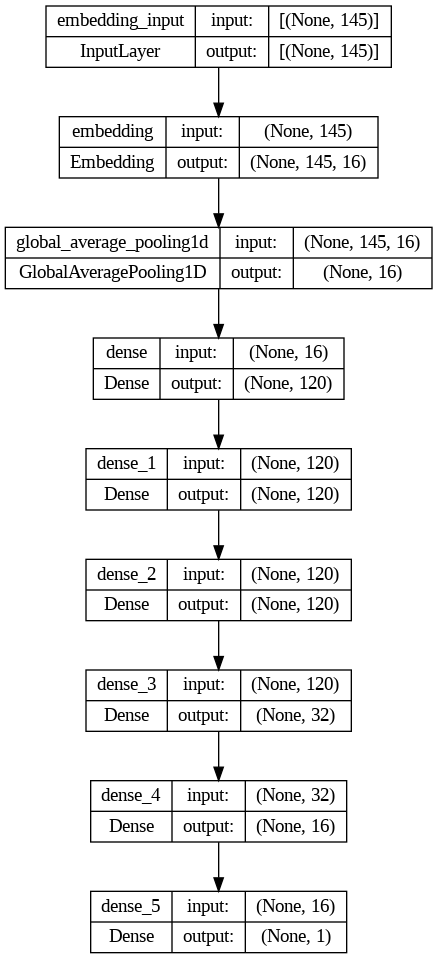

In [ ]:
bow_model = build_bow_model(
    vocab_size=20000, sequence_length=145, embedding_dim=16)
tf.keras.utils.plot_model(bow_model, show_shapes=True)

#### Model Training

In [ ]:
train_df_90_labels = train_df_split['manual_relabeled']

# Reshaping the validation data to be able to fit to the model
val_data = (validation_train_df_reduced, validation_labels.reshape((-1,1)))

Epoch 1/8
429/429 [==============================] - 5s 7ms/step - loss: 0.6806 - accuracy: 0.5720 - val_loss: 0.6454 - val_accuracy: 0.7021
Epoch 2/8
429/429 [==============================] - 3s 7ms/step - loss: 0.5795 - accuracy: 0.7040 - val_loss: 0.5790 - val_accuracy: 0.7139
Epoch 3/8
429/429 [==============================] - 3s 6ms/step - loss: 0.5396 - accuracy: 0.7380 - val_loss: 0.5482 - val_accuracy: 0.7310
Epoch 4/8
429/429 [==============================] - 3s 6ms/step - loss: 0.5115 - accuracy: 0.7584 - val_loss: 0.5856 - val_accuracy: 0.6982
Epoch 5/8
429/429 [==============================] - 2s 6ms/step - loss: 0.4995 - accuracy: 0.7698 - val_loss: 0.5873 - val_accuracy: 0.6850
Epoch 6/8
429/429 [==============================] - 3s 6ms/step - loss: 0.4959 - accuracy: 0.7705 - val_loss: 0.5389 - val_accuracy: 0.7480
Epoch 7/8
429/429 [==============================] - 3s 6ms/step - loss: 0.4867 - accuracy: 0.7748 - val_loss: 0.5487 - val_accuracy: 0.7402
Epoch 8/8
429

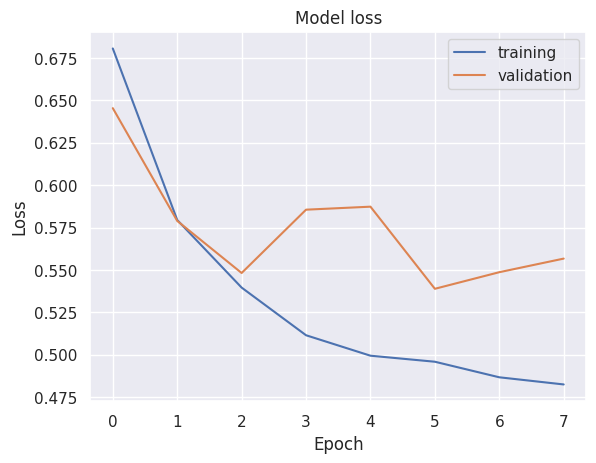

In [ ]:
# Clear session and remove randomness.
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(0)

history = bow_model.fit(
  x = train_df_90_reduced,
  y = train_df_90_labels,          # corresponding binary labels
  epochs=8,             # number of passes through the training data
  batch_size=16,        # mini-batch size
  validation_data = val_data, # passing in the validation data we sectioned
  verbose=1,            # display some progress output during training
  )

plot_history(history)
display(history)

#### Get test predictions

In [ ]:
test_df_encoded_text = test_df['text'].apply(encode)
test_df_padded = pad_data(test_df_encoded_text, max_length=145)
test_df_reduced = limit_vocab(test_df_padded, max_token_id=1000)

##### Thresholding and output to Kaggle

In [ ]:
bow_model_predictions = bow_model.predict(test_df_reduced)
threshold = 0.5
bow_model_binary_predictions = np.where(bow_model_predictions >= threshold, 1, 0)
output_kaggle_test(test_df, bow_model_binary_predictions)

102/102 [==============================] - 0s 2ms/step
(3263, 2)


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


#### Error Analysis

##### Finding F1 for the validation and Kaggle Test set

In [ ]:
bow_validation_predictions = bow_model.predict(validation_train_df_reduced)
threshold = 0.5
bow_validation_binary_predictions = np.where(bow_validation_predictions >= threshold, 1, 0)

24/24 [==============================] - 0s 2ms/step


In [ ]:
# Find the validation set F1
print('For the validation set:')
bow_validation_f1 = calc_F1(bow_validation_binary_predictions, validation_labels)
print()

# Display the kaggle F1
print('The Kaggle test F1 score : 0.74103')

For the validation set:
Accuracy: 0.7467191601049868
Precision: 0.7298245614035088
Recall: 0.6419753086419753


F1: 0.6830870279146142

The Kaggle test F1 score : 0.74103


##### Confusion Matrix

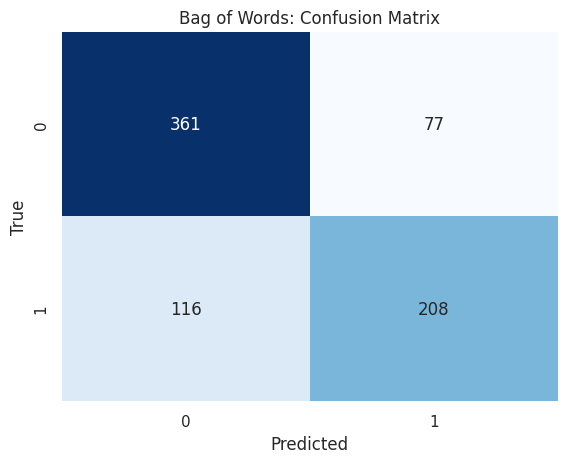

In [ ]:
# Create the confustion_matrix and display
conf_matrix = confusion_matrix(validation_labels, bow_validation_binary_predictions)

# Use the sns heatmap as before
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Bag of Words: Confusion Matrix')
plt.show()

##### ROC Curve

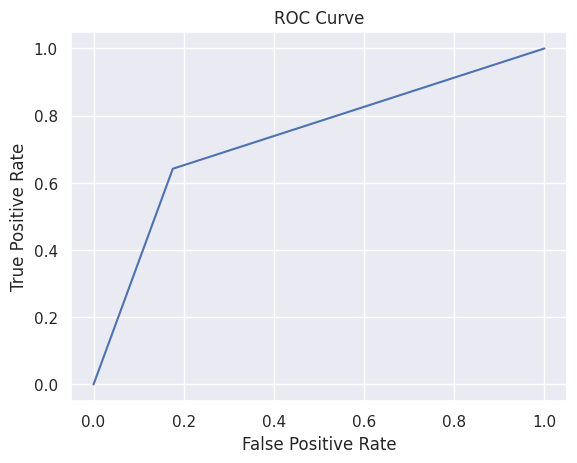

In [ ]:
# Calculate the fpr and tpr values using the roc_curve function
fpr, tpr, thresholds = roc_curve(validation_labels, bow_validation_binary_predictions)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

##### Area Under the ROC curve

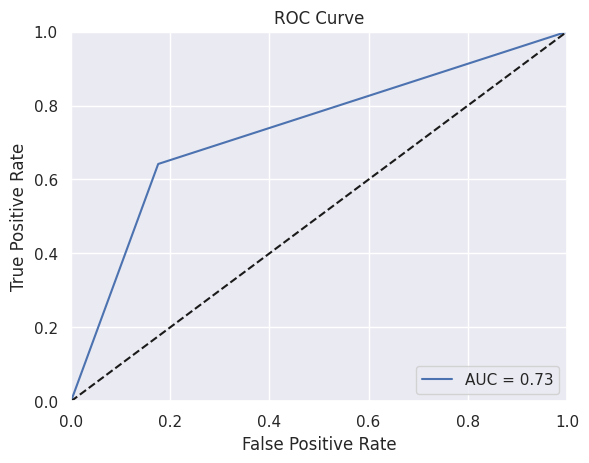

In [ ]:
# Calculate AUC score
auc_score = roc_auc_score(validation_labels, bow_validation_binary_predictions)

# Calculate fpr, tpr values using roc_curve function
fpr, tpr, thresholds = roc_curve(validation_labels, bow_validation_binary_predictions)

# Plot ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

##### Example Errors
To gain insight into why our model may be misclassifying tweets, we opted to showcase five examples of false positives and false negatives.

In [ ]:
# Get the indices for wrong predictions
error_indices = np.where(validation_labels != bow_validation_binary_predictions.reshape(-1))

fp_count, fn_count = 0, 0
i = 0

while fp_count < 5 or fn_count < 5:
    index = error_indices[0][i]
    true_label = validation_labels[index]
    predicted_label = bow_validation_binary_predictions[index]
    
    if true_label == 0 and predicted_label == 1 and fp_count < 5:
        print(f"Text: {validation_df.iloc[index]['text']}")
        print(f"True label: {true_label}, Predicted label: {predicted_label}")
        print("\n")
        fp_count += 1
    
    if true_label == 1 and predicted_label == 0 and fn_count < 5:
        print(f"Text: {validation_df.iloc[index]['text']}")
        print(f"True label: {true_label}, Predicted label: {predicted_label}")
        print("\n")
        fn_count += 1
        
    i += 1


Text:  hell kill me instead if he survived the shot i dont exactly know i fled the scene and pulled the trigger with
True label: 1, Predicted label: [0]


Text: hot  reddits new content policy goes into effect many horrible subreddits banned or quarantined  prebreak best
True label: 1, Predicted label: [0]


Text: the sinking ship  scarlet lane lenore  is on replacing stone saison 
True label: 0, Predicted label: [1]


Text: nearly had a heart attack just now loud bang against window next to meûturns out it was two birds flying into the glass
True label: 1, Predicted label: [0]


Text: listen live  author interview beth underwood of gravity on military mom talkradio
True label: 0, Predicted label: [1]


Text: i may have gotten a little too exited over my home made lava lamp 
True label: 0, Predicted label: [1]


Text: cartoon bears without them we would qave no knowlddge of forest fires or toilet paper
True label: 0, Predicted label: [1]


Text: three days off from work and theyve pre

##### Discussion
Like the BERT model, The Kaggle F1 score for the Bag of Words model is notably higher than the validation set, possibly due to the larger size of the test dataset, allowing the model to generalize better. However, the confusion matrix reveals that the model predicts more false negatives than false positives (even more so than the BERT model), possibly because of the class imbalance in the training dataset. To address this issue, we would recommend augmenting the dataset with more disaster-related tweets.
<br/>
<br/>
The ROC curve provides a graphical representation of the trade-off between the true positive rate (TPR) and the false positive rate (FPR), enabling us to determine the optimal threshold value for our model. The optimal threshold value is the point on the curve closest to the upper left corner, which represents high TPR and low FPR. However, even after identifying the optimal threshold value, which appeared to be approximately 0.7 for Bag of Words, we found that using a threshold value of 0.5 resulted in higher accuracy for the model. This suggests that the threshold value is not the only factor influencing the model's performance, and that other factors, such as the choice of hyperparameters, may also be important.
<br/>
<br/>
The AUC ROC curve, similarly to the ROC curve, provides a visual representation of the trade-off between the true positive rate (TPR) and the false positive rate (FPR). It measures the ability of the model to distinguish between positive and negative classes, regardless of the threshold value used to classify the data.

The Bag of Word's AUC ROC score was identified as 0.73, demonstrating an adequate performing model.
<br/>
<br/>
Upon examining the errors, it appears that the model's incorrect predictions are due to the noise and ambiguity present in the text data and the class imbalance in the dataset. The model may struggle to accurately identify disaster-related tweets, while the bias towards the majority class (non-disaster tweets) further complicates the issue, especially given the synonymous keywords in the text.
<br/>
<br/>
Moreover, the model's training process portrays a possibly overly large learning rate, which is causing the accuracy to oscillate between getting better and worse accuracies. This is due to the adam optimizer's refusal to allow our model to be trained on a specified learning rate.
<br/>
<br/>
The model's hyperparameters, such as the learning rate and batch size, may have also played a role in its performance, although the learning size was determined by the sequential keras model, and the batch size was chosen emperically.
<br/>


##### Analysis
Possible ways to improve the model's performance involve augmenting the training dataset with more disaster-related tweets to address the bias towards the non-disaster class highlighted in the error analysis. One approach to increase the size of the dataset is to use techniques like data synthesis and phrase replacement to generate new training examples.

Moreover, there are more optimizers that could be used with the Bag of Words model, which would allow us to have better control over the learning rate, which may provide better performance, but we decided not to pursue that route due to time restrictions.

### Conclusion

There are several challenges to accurately predicting whether a tweet discusses an actual disaster or not, including class imbalance, noise, and ambiguity in the text data.
<br/>
<br/>
Both the BERT and Bag of Words models achieved higher F1 scores on the Kaggle test dataset than on the validation set, indicating that they were able to generalize well to new data. However, both models struggled with false negatives, potentially due to the class imbalance in the training data, and both required some tuning of the threshold value to optimize performance.
<br/>
<br/>
When compared to the validation set, the F1 scores for the BERT and Bag of Words models were higher on the Kaggle test dataset, demonstrating their ability to generalize well to new data. However, both models had issues with false negatives, maybe as a result of the class imbalance in the training data, and both needed the threshold value to be adjusted to optimize performance.
<br/>
<br/>
Through our analysis, we have identified several strategies to potentially improve the performance of our model. Firstly, addressing the issue of imbalanced training data by generating additional training examples could be an effective solution. Additionally, incorporating a technique such as removing stopwords in our bag of words model may aid in capturing context. It is worth noting that BERT, as a state-of-the-art model, comes equipped with its own preprocessor that is robust to a certain degree of text variability.

Furthermore, we were keen on exploring the use of model ensembling as a means to further enhance our predictions. One promising approach involves ensembling multiple BERT models, each trained on a subset of the training data, or trained on different variations of the data such as unclean versus cleaned text. By leveraging the complementary strengths of different models, we may be able to achieve even better performance on our task.
<br/>
<br/>
Our initial expectations for the performance of the Bag of Words model were surpassed, as we did not anticipate such strong results from a model of its relative simplicity. The resulting F1 score was quite impressive, particularly given our modest expectations at the outset.

However, our optimism for the BERT model did not fully match our expectations. Despite having a large number of trainable parameters, the model did not perform as strongly as we had hoped, and fell short of the 0.90 F1 score target that was initially anticipated. This serves as a powerful reminder of the inherent complexity and ambiguity of natural language processing tasks, particularly given the intricacies of our dataset which is full of synomous textual data which is complex for a model to analyze.
<br/>
<br/>
In conclusion, the project highlights the importance of carefully considering the specific challenges and nuances of the data when designing a machine learning model. While both the BERT and Bag of Words models performed reasonably well, it may be necessary to augment the training data with more disaster-related tweets in order to further improve performance. Additionally, continued exploration of different model architectures and hyperparameters may help to address some of the challenges identified in this project.

### Table of Results

| Model | Validation F1 Score | Kaggle F1 Score |
| :---: | :----------------: | :-------------: |
| Baseline |      0.53906      |     0.63070      |
| Bag of Words Binary Classifier |      0.68308       |     0.74103      |
| BERT |      0.80261      |     0.84737      |
